In [1]:
from __future__ import division
%cd uscproject
#Generic system tools
import re, pprint, sys, json, os, shutil, webbrowser

#Language processing
import nltk

#Saving and retrieving data
from IOMDataService import ShelveDataHandler
import IOMDataService as DS
import ConditionsServiceClasses as CSC

#Searching
import SphinxService as SPX

#Data analysis and plotting
from pandas import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pydot
import pygraphviz

#Classification/clustering
from cosineSimilarity import cosine_simiarlity_analyzer

#Text filtration/stemming/tokenizing
import TextFiltration as TF
from TextFiltration import Words, Bigrams
param = {'replaceContractions' : 'True', 'removePunctuation' : 'True', 'removeStops' : 'True', 'removeNumerals' : 'True'}

#Formatting ipython
import IPython
from IPython.core.display import HTML
from IPython.display import SVG
from IPython.display import Image
from IPython.display import HTML
from IPython.display import display_html
HTML("""
        <style type="text/css">
            table.nowrap {
                margin-right: 80px;
            }
            table.dataframe {
                margin-right: 80px;
            }
        </style>""")

#Initialize service classes
DH = DS.ShelveDataHandler()
CN = CSC.ConditionsService('false')

(bookmark:uscproject) -> /Users/adam/Dropbox/iPythonFiles/USCProject
/Users/adam/Dropbox/iPythonFiles/USCProject


ImportError: No module named ConditionsServiceClasses

#Backstory
In putting together 2011's __Relieving pain in America: A Blueprint for Transforming Prevention, Care, Education, and Research__ the Institute Of Medicine conducted an online survey for healthcare providers, pain patients, and their friends and family to report their experiences with American pain medicine.

![Alt iomreport](http://images.nap.edu/images/cover.php?id=13172)

Dr. Steven Richeimer of the USC Pain Center obtained the raw results. He asked me if I'd like to work on a project to analyze the narratives. 

Unfortunately, as you can see from running the query below a couple of times, the answers varied widely. 

Moreover, there were six questions in the survey form. The prompts were usually ignored. There was very little order to the data to begin with.


In [3]:
def randomQuotes():
    Q = DS.QueryShell()
    qy = "SELECT quoteText FROM testimony ORDER BY RAND() LIMIT 3"
    Q.query(qy, [])
    Q.returnAll()
    display(HTML(Q.dbdata[0]['quoteText']))
i=0
for i in range(3):
    randomQuotes()
    print '---------------------------'
    i += 1

---------------------------


---------------------------


---------------------------


We're (mostly) interested in the testimonies of people with pain conditions. Unfortunately, the IOM survey did not ask whether a whether the respondent was a clinician, a chronic pain patient, or otherwise a stakeholder in pain care (demographic information would've been nice too). 

Using MySQL and profanity, I eventually sorted the records into three groups: 
>**Patients** 

> * A respondent is a *patient* if she reports experiences from the point of view of a person experiencing pain or seeking treatment for pain.

>**Providers**

> * A respondent is a *provider* if she reports experiences from the point of view of a person providing treatment for pain. This includes medical professionals, parents, children, et cetera.

>**Uncategorized**

> * Respondents which couldn't be categorized as a patient or a provider.

There was some overlap between the patients and providers. For example,

In [4]:
Q = DS.QueryShell()
qy = "SELECT quoteText FROM testimony WHERE quoteID = 1889 OR quoteID = 1891"
display_html(Q.query(qy, []))

[{'quoteText': 'From personal experience, I can attest to the lack of research, knowledge, and focus on pelvic pain disorders in women.  I suffer from vestibulodynia and find that my doctors are well-intentioned but have little solid research to base their treatment decisions on.'},
 {'quoteText': 'I am a registered nurse in a program to become a Family Nurse Practitioner.  I have so far only been ancillary to patients with chronic pain but know they all have stories of the frustrating long slow road to finding relief.....in the hospital in my role as a acute care nurse, I see many doctors take people off of their regular pain control regimens.  Sometimes the reasons seem justified; often they do not - but seem to stem from narcophobia.  These patients, who have specialists in pain control in their regular lives, and who probably spent years arriving at a regimen that works, are then taken off of those drugs and told to "suck it up.""  It is very hard to watch.  It is my strong opinion

We had **2007 unique respondents**, of whom:

> **1369** were classified as **patients**

> **99** were classified as **providers**

> **25** were classified as **both** a patient and a provider

> **564** were classified as **neither** a patient nor a provider

From these respondents, we had **4,859** vignettes. **3,864** were from **patients**.

# Classification: Do patients with different conditions use different language?

Given that chronic pain conditions affect a person's life in different ways, there might be similarities between the testimonials of patients reporting similar conditions. 

We can treat this as a classification task. That is, we first give an algorithm a subset of testimonials from patients with identified conditions. Then, if it can correctly classify a reasonable number of the rest, we can look at what features the algorithim relied on. (For very simple algorthims) 

Usually, the goal of classification algorithm is to produce models which accurately sort unknown documents into categories (e.g., spam detection). These algorithms and models can be extremely complex. 

However, we are interested in something else. We want to know which words matter the most in the classification. Thus models which invoke many different statistical properties of the text (e.g., the mean occurance of 'cat', the z score of 'dog', the median occurance of 'fish') are unlikely to be helpful. Whereas, Bayesian models which calculate the probability of a document falling into a paricular category when it has a particular set of words are much more useful.

We start by seperating the testimonials into lists of words (tokenizing), making everything lowercase, and filtering the testimonials on these parameters:

> * replaceContractions : 'True' 
> * removePunctuation' : 'True'
> * removeStops : 'True'
> * removeNumerals : 'True'

Given the computation this requires, I'll just load it from a shelve file.

In [21]:
#Load data
tn_raw_data = DH.openData('tn_raw_data') #raw records of tn patients
tn_word_bag = DH.openData('tn_word_bag') #tokens of tn testimonials
crps_raw_data = DH.openData('crps_raw_data') #crps patients' testimonials 
crps_word_bag = DH.openData('crps_word_bag') #tokens of crps testimonials
#Compile testimonials
RAW = [] 
RAW.extend(tn_raw_data)
RAW.extend(crps_raw_data)
#Aggregate all tokens
masterBag = [] #Holds all tokens
for t in tn_word_bag:
    masterBag.append(t)
for t in crps_word_bag:
    masterBag.append(t)
#display(HTML({'Trigeminal neuralgia testimonials' : len(tn_raw_data), 'Complex Regional Pain Syndrome testimonials' : len(crps_raw_data), 'Total records' : len(RAW)}))
                               

[note] Describe filtering out condition names here? 

Then we compute the frequency distribution of words in the entire set.

In [22]:
all_words = nltk.FreqDist(masterBag)
word_features = all_words.keys()[:2000]

The classifer requires us to tell it what aspects of the text to attend to. For that we define a feature extractor:

In [23]:
#Feature extractor: Presence of word in document
def document_features(document):
    document_words = []
    w = Words(document, param) #Tokenized by word, contractions replaced, numerals removed
    document_words = set(list(w.words))
    features ={}
    for word in word_features:
        features['contains(%s)' % word] = word in document_words
    return features

Since we are interested in whether the use of particular words is more distinctive of the testimonies of patients with a particular condition, this feature extractor compares the words in the target document to our list of all the words that appear in the entire set. It returns a python dictionary where the keys comprise all the words in the set with True or False for whether the word appears in the target document. The classifier gets a list of these dictionaries as its input.

In [24]:
exampleText = """Women are frequently told that are problems are related to our hormone cycle or our stress or our emotional state. Would men 
put up with a doctor telling them that their chronic pain is related to their testosterone or their job or if their football team lost?."""
result = document_features(exampleText)
resultlist = []
[resultlist.append((word, presence)) for word, presence in result.iteritems()]
display(HTML(DataFrame(resultlist[220:230]).to_html()))

,0,1
0,contains(com),False
1,contains(place),False
2,contains(groups),False
3,contains(multiple),False
4,contains(problems),True
5,contains(clinical),False
6,contains(kind),False
7,contains(worst),False
8,contains(pregnant),False
9,contains(imporant),False


We need to divide our list of feature sets into a group to be used for training the classifier and a group to test the resulting classifier's accuracy. 

In [25]:
#Make featuresets for each of our groups
tn_featureset = [(document_features(t['quoteText']), 'tn') for t in tn_raw_data]
crps_featureset = [(document_features(c['quoteText']), 'crps') for c in crps_raw_data]
#Combine the two lists
featureset = []
[featureset.append(i) for i in tn_featureset]
[featureset.append(i) for i in crps_featureset]
#Randomize the master featureset
random.shuffle(featureset)
#Separate into training and test sets
trainset, testset = featureset[:1000], featureset[:1000] 

##Naive Bayesian classifier

The most useful classifier I've used so far employs a naive Bayesian analysis. Let's start it running and then talk about what it's doing. Some background may help since we aren't (as) interested in the usual classification tasks of sorting unknown documents into categories (e.g., spam detection). 

In [26]:
#Run naive bayesian classifier on training set
bayes_classifier = nltk.NaiveBayesClassifier.train(trainset)

#### How Naive Bayesian classifiers work
These algorithms begin by calculating the prior probability of each label by checking the frequency of each label in the training set. So, here, the prior probability of the label 'tn' is just P(tn) such that P(tn) + P(crps) = 1. Since there are 15 trigeminal neuralgia records and 35 CRPS records, 
>P(tn) = 0.3
>P(crps) = 0.7

The classifier then calculates each feature's contribution to the label. Here, features are just words. So the contribution of the feature 'doctor' ---the occurance of the word 'doctor'--- to the label tn in the training set for trigeminal neuralgia is P('doctor' | 'tn'). 

From this it calculates a likelihood estimate for each label by multiplying the prior probability with the contributions of each feature to the label. Thus the label liklihood is P(label, set of features). In other words, it's an estimate of the probbility that a randomly selected value from the training set would have both the given label and the set of features, assuming that the feature probabilies are indpendent.

That last clause is, of course, crucial. The _independence assumption_ dramatically simplifies the calculation. And it's why this is the _naive_ Bayesian classifier. It poses a problem of double counting the contributions of non-independent features. 

Other classifiers, such as the maximum entropy classifiers avoid this (with their own tradeoffs). Back to that in a minute.

In [1]:
tn_word_bag.count('doctor')

NameError: name 'tn_word_bag' is not defined

Once it has completed, we take the remaining featureset to check how accurately the model can sort the previously unseen testimonials.

In [28]:
print 'Accuracy: ', nltk.classify.accuracy(bayes_classifier, testset)

Accuracy:  0.901960784314


That is, our classifier was 90% accurate. However, this is actually a sign that the model is bad. Given the small training and test sample sizes, it's likely that the model is more or less just memorizing the list.


Moreover, it's important to remember that accuracy in classificaton is not our main concern. Usually, the goal of classification algorithm is to produce models which accurately sort unknown documents into categories (e.g., spam detection). These algorithms and models can be extremely complex. 

However, we are interested in something else. We want to know which words matter the most in the classification. Thus more accuracte models which invoke many different statistical properties of the text (e.g., the mean occurance of 'cat', the z score of 'dog', the median occurance of 'fish') are unlikely to help us.

For our purposes, accuracy is important insofar as it is a property of models which can be more informative than mere term frequency.

We can then open the box and see what words the model treated as most important

In [29]:
display(HTML(bayes_classifier.show_most_informative_features()))

Most Informative Features
         contains(state) = True               tn : crps   =      8.3 : 1.0
        contains(issues) = True               tn : crps   =      8.3 : 1.0
      contains(followed) = True               tn : crps   =      6.8 : 1.0
          contains(hope) = True               tn : crps   =      5.3 : 1.0
         contains(women) = True               tn : crps   =      5.3 : 1.0
       contains(working) = True               tn : crps   =      5.3 : 1.0
         contains(thing) = True               tn : crps   =      5.3 : 1.0
       contains(complex) = True               tn : crps   =      5.3 : 1.0
        contains(easily) = True               tn : crps   =      5.3 : 1.0
       contains(program) = True               tn : crps   =      5.3 : 1.0


This shows that the words 'state' and 'issues' are 8.3 times more likely to occur in a trigeminal neuralgia patient's testimonal than in a CRPS patients' testimonial. On their own, these aren't particularly interesting. However, a trigeminal neuralgia patient's testimonial is 5.3 times more likely to mention 'women'. That's worth looking into.   

###Decision tree clasifier
I've also tried a decision tree classifier

In [30]:
dt = nltk.DecisionTreeClassifier.train(trainset)
print dt
print nltk.classify.accuracy(dt, testset)

contains(trigeminal)=False? ........................... crps
contains(trigeminal)=True? ............................ tn

1.0


Perhaps these will be more useful on larger, more diverse groups. But with this small set, it's not so useful....

###Max entropy classifiers

We can talk about these in the Q&A later.....

#And now for something completely different.....

Sorry. I'm told at least one Monty Python reference is compulsory in any Python-based presentation....


# Visualizing mentions of pain disorders as networks?

Respondents to the IOM survey often mention pain conditions. In many cases they mention more than one. Thus it is interesting to consider whether mentions of particular conditions tend to cluster together. 

Unfortunately, the IOM survey didn't ask respondents to record which pain conditions they have experience with. Thus we are only dealing here with the occurrances of words and not necessarily the presence of a condition. 

Moreover, even amongst the respondents identified as patients, the cooccurance of conditions does not necessarily mean that they are reporting suffering from both. For example, our techniques would treat the following the same:

* 'The problem is that people with fibromyalgia get all the attention. Everyone ignores people, like me, who have trigeminal neuralgia.'

* 'I have both fibromyalgia and trigeminal neuralgia.'

However, inspection of the testimony suggests that such cases are likely exceedingly rare (if present at all).

In [31]:
#Number of patients in our sample who report one condition; who report at least two 
#Data for each condition

We begin by using a data service class to load a list of dictionaries containing condition names and ids. It also loads lists of associations between conditions and respondents, associations between testimonials and conditions. (Though we may not use them here)

In [34]:
reload(CSC)
C = CSC.ConditionsService('false')
C.load_all()
#DataFrame(C.conditions)

A list comprising all condition names and ids has been loaded as self.conditions
A list comprising all aliases and ids has been loaded as self.aliases
A list of which respondents correspond to which conditions has been loaded as self.respondentsXconditions
A list of all respondents identified as patients and their conditions has been loaded as self.patientsXconditions
A list of conditions associated with each quote has been loaded as self.quotesXconditions
A list of associations for quotes from patients has been loaded as self.patient_quotesXconditions
A list of which conditions are mentioned in each testimonial has been loaded as self.mainxcond


# This needs to be redone with the bimodal network stuff

Once the associations have been loaded, we need to create lists of vectors for the condition terms. 

First, for each condition we find the id of each testimonial in which it occurs. For each result we store a dictionary comprising the conditionID, conditionName, and testimonial id (quoteID) in the list **condition_quote_vectors**. 

We will be using the **Pandas data analysis toolkit** module. We thus make a Series object **quotes_per_condition** with the condition_quote_vectors. 

Remember that this group covers every testimonial. A doctor's report that she sees many patients with fibromyalgia, and an unemployed steel worker's account of fibromyalgia's toll on his life will both be represented here.

We do the same for the respondents who mention the condition at least once. Those go into **respondent_main_vectors** and the pandas Series **responses_per_condition**, respectively. Remember, this group also covers every testimonial.

In [38]:
#Service class does the heavy lifting and makes vectors
C.make_vectors()

#Make a series for number of testimonials mentioning condition
for r in C.testimonial_vectors:
    a[str(r['conditionName'])] = len(r['edge'])
testimonials_per_cond = Series(a)

#Make a series for number of respondents per condition
for r in C.respondent_vectors:
    f[str(r['conditionName'])] = len(r['edge'])
respondents_per_condition = Series(f) 

#Make a series for number of patients mentioning condition
for r in C.patient_vectors:
    a[str(r['conditionName'])] = len(r['edge'])
patients_per_condition = Series(a)

#Combine into one dataframe
combined = DataFrame(responses_per_condition, columns=['responses_per_condition'])
combined['quotes_per_condition'] = quotes_per_cond
combined['patients_per_condition'] = patients_per_condition

#Show the nice people what you've made
display(HTML("<h2>Breakdown</h2>"))
display(HTML(combined.to_html()))

KeyError: 'edge'

NameError: name 'responses_per_condition' is not defined

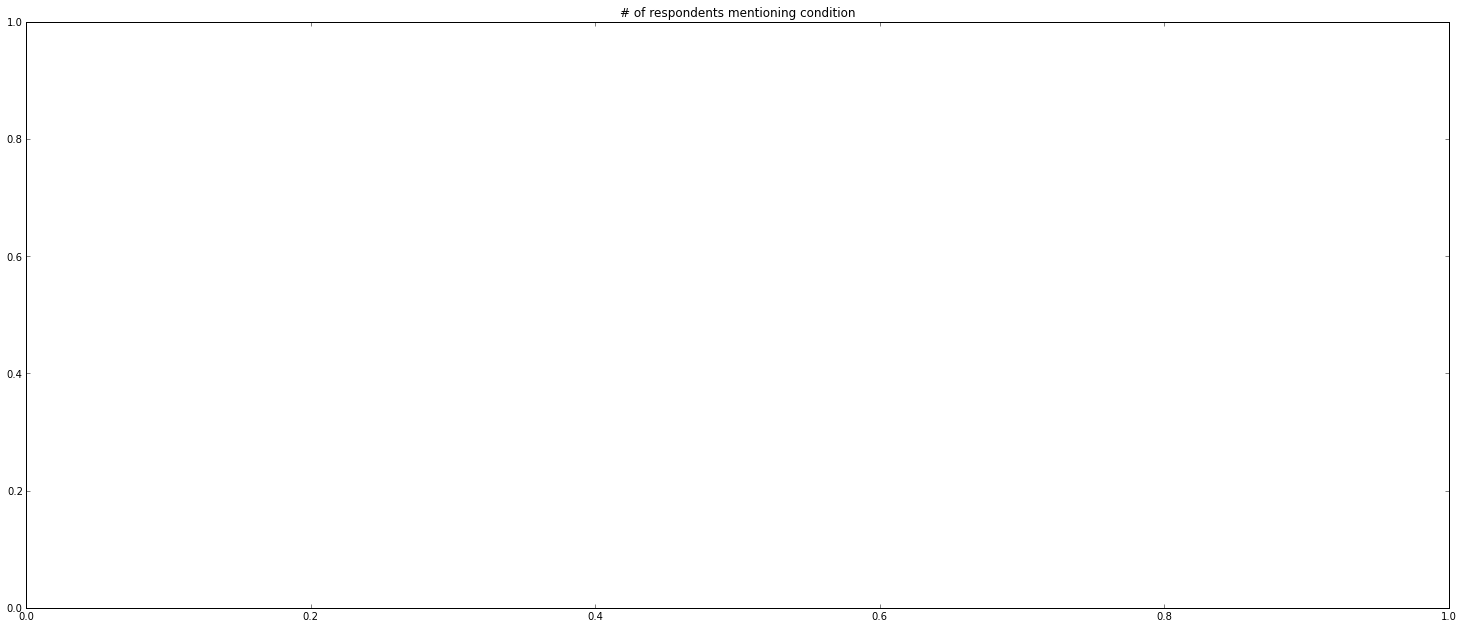

In [6]:
plt.figure()
plt.title('# of respondents mentioning condition')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(25.5,10.5)
#plt.set_size_inches(25.5,10.5)
responses_per_condition.plot(kind='barh')

plt.figure()
plt.title('# of (patient) testimonials mentioning condition')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(25.5,10.5)
quotes_per_cond.plot(kind='barh')

plt.figure()

combined.plot(kind='barh')
fig = matplotlib.pyplot.gcf()
#fig.title('Combined')
fig.set_size_inches(25.5,10.5)

#fig = matplotlib.pyplot.gcf()
#fig.set_size_inches(25.5,10.5)
#fig.plot()
#plt.savefig('charts_and_graphs/resp_quote_cond',dpi=100)

###__Conditions which co-occur in a testimonial__

>Each __node__ is a **condition**
>
>Each __edge__ is a **person**

####Notes
* Non-reflexive relationships aren't possible. If condition c1 co-occurs with c2 in testimonal T1, then c2 co-occurs with c1 in T1. 

In [143]:
#Quotes mentioning condition
#Create lists of nodes and edges
nodes = []
edges = [] #List of tuples with cond in [0]
for v in condition_quote_vectors:
    cond = v['conditionName']
    nodes.append(cond)
    cid = v['conditionID']
    qs = v['quotes']
    #loop through all other lists looking for hits
    for a in condition_quote_vectors:
        if a['conditionName'] != cond: #Don't want to count self
            for i in a['quotes']:
                if i in qs:
                    edges.append((cond, a['conditionName']))
g = nx.DiGraph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
nx.write_gexf(g, 'charts_and_graphs/conditionsXquotes.gexf')
#Export the graph to pydot, configure and print
#nx.to_pydot(g)
#dd = nx.write_dot(g, 'cxq')
#gh = pydot.graph_from_dot_file('cxq')
#gh.set_concentrate(True)
#gh.write_png('ex5.png')
#gh.set_name('Conditions_mentioned_in_testimonies')
#gh.set_page('8.5,11')
#gh.set_ratio('auto')

#gh.write_svg('charts_and_graphs/conditionsXquotesS.svg')
#var = ''
#v = gh.create_svg('svg')
#IPython.core.display(SVG(v))

#gh.write_svg(var)
#IPython.core.display.display_svg(var)
#n.core.display(SVG('charts_and_graphs/conditionsXquotes.svg'))
#IPython.core.display(SVG('charts_and_graphs/conditionsXquotes.svg'))
#IPython.core.display_svg('charts_and_graphs/conditionsXquotes.svg')

In [133]:
gh.create?

###__Respondents mentioning conditions__

>Each __node__ is a **condition**
>
>Each __edge__ is a **person**

In [158]:
#Create lists of nodes and edges
rxm_nodes = []
rxm_edges = [] #List of tuples with cond in [0]
for v in respondent_main_vectors:
    cond = v['conditionName']
    nodes.append(cond)
    cid = v['conditionID']
    qs = v['respondents']
    #loop through all other lists looking for hits
    for a in respondent_main_vectors:
        if a['conditionName'] != cond: #Don't want to count self
            for i in a['respondents']:
                if i in qs:
                    edges.append((cond, a['conditionName']))
gr = nx.DiGraph()
gr.add_nodes_from(nodes)
gr.add_edges_from(edges)
nx.write_gexf(gr, 'charts_and_graphs/Conditions_mentioned_by_respondent.gexf')
#nx.to_pydot(gr)
#nx.write_dot(gr, 'cxr')
#rxmg = pydot.graph_from_dot_file('cxr')
#rxmg.set_name('Conditions_mentioned_by_respondent')
#rxmg.set_concentrate(True)
#gh.write_png('ex5.png')
#rxmg.write_svg('charts_and_graphs/conditionsXrespondent.svg')

#Clustering: Are the most similar testimonies from people with clinically significant properties?

* Condition
* Sex
* Disability status
* Medication use
* Street drug history
* Personality traits
* Comorbidities (non-pain)

#Clustering: Are the most similar testimonies from people with similar non-clinical sequlae?

* Anger
* Depression
* Financial distress
* Multiple doctors
* Time to diagnosis
* Marital status

Look for conjunctions like 'doctor' and 'will not'; 'job' and 'lost'; 'work' and 'cannot'

## Look Mom! No hands!

### ...or, what if we try it without knowing the conditions?



In [ ]:
#the module needs a function to tell whether searchd is on (maybe to start if not

In [50]:
QS = DS.QueryShell()
query2 = """select conditionAlias from conditionAliases limit 260"""
val = []
QS.query(query2, val)
conditions = QS.dbdata

cons = []
[cons.append('"' + t['conditionAlias'] + '"') for t in conditions] 
concatenatedConditions = ' | '.join(cons)
#display_html(concatenatedConditions)

'"Fibromyalgia" | "FM" | "Ankylosing Spondylitis" | "post polio syndrome" | "OA" | "TMJ" | "migraine" | "migraines" | "IC" | "IBS" | "Interstitial Cystitis" | "Osteoarthritis" | "RSD" | "CRPS" | "CFS" | "R.S.D." | "Chronic fatigue syndrome" | "C.R.P.S." | "causalgia" | "Irritable Bowel Syndrome" | "Temporomandibular joint disorder" | "fibro" | "Lower back pain" | "Sickle cell disease" | "Endometriosis" | "fibromalgia" | "fibromialgia" | "fibromyagia" | "fibromyaglia" | "fibromyalgia" | "fibromyalsia" | "fibromylagia" | "fibromylgia" | "fms" | "fm" | "cfs" | "cpps" | "Ehlers-Danlos Syndrome" | "diabetes" | "diabetic" | "diabetics" | "dyspareunia" | "cervical dystonia" | "cranial dystonia" | "dystonia" | "Muscular dystrophy" | "endometriosis" | "Lichen sclerosus" | "lumbar" | "lupus" | "myalgia" | "myofacial" | "myofascial" | "muscluoskeletal" | "osteoporosis" | "pancreatitis" | "psoriatic" | "ptsd" | "rheumatoid arthritis" | "rsd" | "rsds" | "Chronic regional pain syndrome" | "sciatica"

In [51]:
sx = SPX.SphinxSearch()
sx.setPresetTables('iomMain')
maskedquotes = sx.mask_term(concatenatedConditions)

Don't forget to start sphnix from the terminal: 
cd /usr/local/sphinx
sudo searchd
Ready to search IOM testimony_all 
search failed
0  records have been masked to remove  "Fibromyalgia" | "FM" | "Ankylosing Spondylitis" | "post polio syndrome" | "OA" | "TMJ" | "migraine" | "migraines" | "IC" | "IBS" | "Interstitial Cystitis" | "Osteoarthritis" | "RSD" | "CRPS" | "CFS" | "R.S.D." | "Chronic fatigue syndrome" | "C.R.P.S." | "causalgia" | "Irritable Bowel Syndrome" | "Temporomandibular joint disorder" | "fibro" | "Lower back pain" | "Sickle cell disease" | "Endometriosis" | "fibromalgia" | "fibromialgia" | "fibromyagia" | "fibromyaglia" | "fibromyalgia" | "fibromyalsia" | "fibromylagia" | "fibromylgia" | "fms" | "fm" | "cfs" | "cpps" | "Ehlers-Danlos Syndrome" | "diabetes" | "diabetic" | "diabetics" | "dyspareunia" | "cervical dystonia" | "cranial dystonia" | "dystonia" | "Muscular dystrophy" | "endometriosis" | "Lichen sclerosus" | "lumbar" | "lupus" | "myalgia" | "myofacial" | "myofasci

In [54]:
sphinx = SPX.SphinxSearch()
sphinx.setPresetTables('iomMain')
sphinx.search(maskedquotes)
sphinx.getContent()
sphinx.buildExcerpts()

Don't forget to start sphnix from the terminal: 
cd /usr/local/sphinx
sudo searchd
Ready to search IOM testimony_all 
search failed


# Sentiment analysis

# Good ol' term frequency: What did I miss?

....and why is this supposed to be awesome?

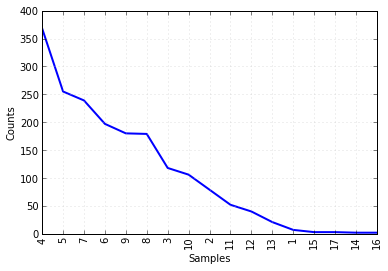

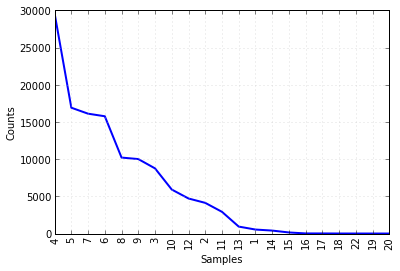

In [57]:
tn_raw_data = DH.openData('tn_raw_data') #raw records of tn patients
tn_word_bag = DH.openData('tn_word_bag') #tokens of tn testimonials
crps_raw_data = DH.openData('crps_raw_data') #crps patients' testimonials 
crps_word_bag = DH.openData('crps_word_bag') #tokens of crps testimonials
fm_raw_data = DH.openData('fm_raw_data') #fm patients' testimonials 
fm_word_bag = DH.openData('fm_word_bag') #fm of crps testimonials

#frequency distribution of word lengths
#word_length_frequency = nltk.FreqDist([len(w) for w in word_bag])
#word_length_frequency.items()
#word_length_frequency.plot(cumulative=False)
#frequency distribution of word lengths
tn_word_length_frequency = nltk.FreqDist([len(w) for w in tn_word_bag])
#word_length_frequency.items()
tn_word_length_frequency.plot(cumulative=False)
#frequency distribution of word lengths
fm_word_length_frequency = nltk.FreqDist([len(w) for w in fm_word_bag])
#word_length_frequency.items()
fm_word_length_frequency.plot(cumulative=False)


In [58]:
#words_by_freq = nltk.FreqDist(word_bag)
tn_words_by_freq = nltk.FreqDist(tn_word_bag)
fm_words_by_freq = nltk.FreqDist(fm_word_bag)

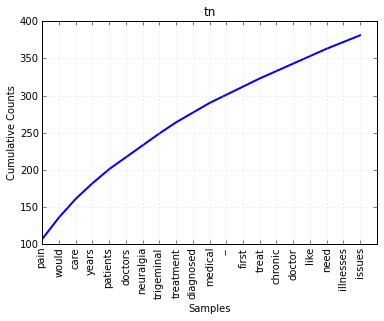

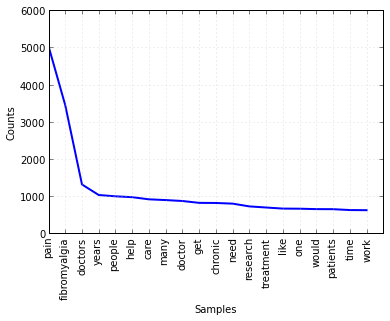

In [60]:
#words_by_freq.plot(20, cumulative=True)
tn_words_by_freq.plot(20, cumulative=True, title='Trigeminal neuralgia')
fm_words_by_freq.plot(20, cumulative=False, title='Fibromyalgia')